**Importing the libraries**



In [ ]:
%pylab inline
import tensorflow as tf
import os
import random
import pandas as pd
import cv2
import numpy as np
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,LeakyReLU,BatchNormalization,ReLU
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Loading the data**

In [ ]:

train = pd.read_csv("train.csv")


In [ ]:

##Train folder contains two folders
#1 Train which contains training data
#2 Val which contains validation data

temp1 = []
temp2 = []
y_train = []
y_val = []
#Loop through images and grab their id and label
for id,lable in zip(train.ID,train.Class):
  imgPath_t = os.path.join('Train/Train',id)
  imgPath_v = os.path.join('Train/Val',id)
  #if image is present in the Train folder add it to the x_train array
  if(os.path.exists(imgPath_t)):
    img = cv2.imread(imgPath_t)
    img = cv2.resize(img,(64,64))
    img = img.astype('float32')
    temp1.append(img)
    y_train.append(lable)
#else its present in the Val folder 
  else:
    #add it to the x_val array
    img = cv2.imread(imgPath_v)
    img = cv2.resize(img,(64,64))
    img = img.astype('float32')
    temp2.append(img)
    y_val.append(lable)
  
#stack arrays to get a numpy array
x_val = np.stack(temp2) 
x_train = np.stack(temp1) 
y_val = np.stack(y_val) 
y_train = np.stack(y_train) 




In [ ]:
lb = LabelEncoder()
#use the label encoder to encode the labels in the y_train array
y_train = lb.fit_transform(y_train)
#transform it into a one hot encoder array
y_train = np_utils.to_categorical(y_train)

In [ ]:
#divide by 255 to normalize the x_val array
x_val = x_val / 255.
lv = LabelEncoder()
#use the label encoder to encode the labels in the y_val array
y_val = lv.fit_transform(y_val)
#transform it into a one hot encoder array
y_val = np_utils.to_categorical(y_val)

In [ ]:
print("x_train : " ,x_train.shape)
print("y_train : ",y_train.shape)
print("x_val : ",x_val.shape)
print("y_val : ",y_val.shape)

x_train :  (16014, 64, 64, 3)
y_train :  (16014, 3)
x_val :  (3892, 64, 64, 3)
y_val :  (3892, 3)


In [ ]:
#Use ImageDataGenerator to generate augmented images from the original ones
#apply rescaling so the image data would always be normalized
#apply some random distortion to the image like rotating,flipping,shearing
train_gen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)

In [ ]:
model = Sequential()
#Add a convlotuional layer with 64 filters each of size 3x3
#images have been rescaled to 64x64 so they are fed as input to the first layer
model.add(Conv2D(64, (3, 3), input_shape = (64, 64, 3)))
#apply LeakyRelu function to in
model.add(LeakyReLU(0.3))

model.add(Conv2D(128, (3, 3)))
model.add(LeakyReLU(0.3))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2) ,strides = (2,2)))
# Dropout
model.add(Dropout(0.3))
#Max Pooling
model.add(Conv2D(128, (3, 3)))
model.add(MaxPooling2D(pool_size = (2, 2) , strides = (2,2)))
model.add(LeakyReLU(0.3))
model.add(BatchNormalization())
# Dropout
model.add(Dropout(0.4))
#Flatten
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(0.3))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
#use this only if you want to load weights from a previously trained model
#model.load_weights('weights.h5')

In [ ]:
model.compile(loss='categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])

In [ ]:
h = model.fit(train_gen.flow(x_train, y_train, batch_size=32),steps_per_epoch=len(x_train) / 32, epochs=50,validation_data = (x_val,y_val))

Epoch 1/50
500/500 [==============================] - 22s 43ms/step - loss: 5.6658 - accuracy: 0.4849 - val_loss: 0.8995 - val_accuracy: 0.5938
Epoch 2/50
500/500 [==============================] - 21s 42ms/step - loss: 1.2211 - accuracy: 0.5648 - val_loss: 0.7861 - val_accuracy: 0.6408
Epoch 3/50
500/500 [==============================] - 21s 43ms/step - loss: 0.8315 - accuracy: 0.6474 - val_loss: 0.7235 - val_accuracy: 0.6873
Epoch 4/50
500/500 [==============================] - 21s 42ms/step - loss: 0.7553 - accuracy: 0.6729 - val_loss: 0.7213 - val_accuracy: 0.6837
Epoch 5/50
500/500 [==============================] - 22s 43ms/step - loss: 0.7429 - accuracy: 0.6823 - val_loss: 0.7657 - val_accuracy: 0.6590
Epoch 6/50
500/500 [==============================] - 21s 43ms/step - loss: 0.7183 - accuracy: 0.6968 - val_loss: 0.6924 - val_accuracy: 0.7004
Epoch 7/50
500/500 [==============================] - 21s 43ms/step - loss: 0.7170 - accuracy: 0.6935 - val_loss: 0.7090 - val_accuracy:

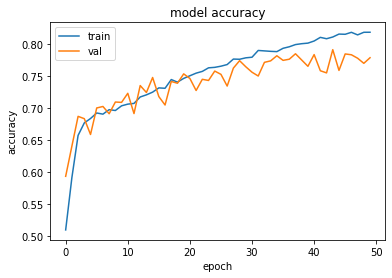

In [ ]:
#save weights
model.save_weights('weights.h5')
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

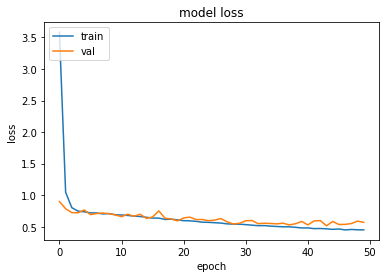

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()